In [18]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pywt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
import talib




In [19]:
data = pd.read_csv('BTCUSDT_PERPETUAL.csv',parse_dates=True , index_col='open_time')
data

,Open,High,Low,Close,Volume,close_time,quote_volume,trades_num,taker_buy_volume,taker_buy_quote_volume
open_time,,,,,,,,,,
2020-12-31 16:00:00,28792.58,28837.77,28782.46,28832.70,293.514,2020-12-31 16:00:59.999,8.456309e+06,2280,159.698,4.601449e+06
2020-12-31 16:01:00,28832.69,28836.72,28733.12,28746.85,313.979,2020-12-31 16:01:59.999,9.037019e+06,2529,70.785,2.037393e+06
2020-12-31 16:02:00,28748.05,28760.00,28700.47,28715.85,350.483,2020-12-31 16:02:59.999,1.006867e+07,2600,109.508,3.146607e+06
2020-12-31 16:03:00,28714.66,28739.75,28706.00,28711.42,199.614,2020-12-31 16:03:59.999,5.733296e+06,1514,75.826,2.178253e+06
2020-12-31 16:04:00,28711.43,28749.21,28700.00,28735.53,225.339,2020-12-31 16:04:59.999,6.471661e+06,1767,116.240,3.339144e+06
...,...,...,...,...,...,...,...,...,...,...
2024-03-26 23:55:00,70126.20,70126.20,70085.90,70086.00,48.272,2024-03-26 23:55:59.999,3.384086e+06,956,23.199,1.626346e+06
2024-03-26 23:56:00,70085.90,70121.00,70068.40,70109.80,50.604,2024-03-26 23:56:59.999,3.547237e+06,1071,39.824,2.791659e+06
2024-03-26 23:57:00,70109.70,70109.80,70042.50,70042.90,42.607,2024-03-26 23:57:59.999,2.985270e+06,846,17.339,1.214848e+06


In [20]:
data = data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})

In [21]:
data = data.drop(data.columns[data.columns.get_loc('volume')+1:], axis=1)
data

,open,high,low,close,volume
open_time,,,,,
2020-12-31 16:00:00,28792.58,28837.77,28782.46,28832.70,293.514
2020-12-31 16:01:00,28832.69,28836.72,28733.12,28746.85,313.979
2020-12-31 16:02:00,28748.05,28760.00,28700.47,28715.85,350.483
2020-12-31 16:03:00,28714.66,28739.75,28706.00,28711.42,199.614
2020-12-31 16:04:00,28711.43,28749.21,28700.00,28735.53,225.339
...,...,...,...,...,...
2024-03-26 23:55:00,70126.20,70126.20,70085.90,70086.00,48.272
2024-03-26 23:56:00,70085.90,70121.00,70068.40,70109.80,50.604
2024-03-26 23:57:00,70109.70,70109.80,70042.50,70042.90,42.607


In [22]:
rule = '4h'

d1 = data.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = data.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = data.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = data.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = data.resample(rule=rule, closed='left', label='left').sum()[['volume']]

df = pd.concat([d1,d2,d3,d4,d5], axis=1)
df['return'] = df['close'].pct_change()
df.dropna(inplace = True)
df

,open,high,low,close,volume,return
open_time,,,,,,
2020-12-31 20:00:00,28917.08,29199.49,28800.00,28951.68,25067.611,0.001197
2021-01-01 00:00:00,28948.19,29546.42,28706.00,29302.11,43210.161,0.012104
2021-01-01 04:00:00,29302.11,29422.32,28822.00,29107.71,26682.086,-0.006634
2021-01-01 08:00:00,29107.72,29454.45,28900.00,29341.99,29562.630,0.008049
2021-01-01 12:00:00,29342.00,29668.86,29043.75,29210.84,49142.952,-0.004470
...,...,...,...,...,...,...
2024-03-26 04:00:00,70473.70,71649.00,70302.40,70535.00,50356.280,0.000868
2024-03-26 08:00:00,70535.00,71340.80,70295.90,70734.20,44137.268,0.002824
2024-03-26 12:00:00,70734.10,71200.00,69320.00,70307.10,101981.595,-0.006038


In [23]:
def calculate_technical_indicators(df):
    df = df.copy()
    close = df['close']
    high = df['high']
    low = df['low']
    volume = df['volume']
    
    # MACD and Signal Line High
    df['MACD'], df['Signal Line'], _ = talib.MACD(close)
    df['MACD_High'] = df[['MACD', 'Signal Line']].max(axis=1)
    
    # MACD Histogram Low
    df['MACD_Histogram'] = talib.MACD(close)[2]
    df['MACD_Histogram_Low'] = df['MACD_Histogram'].min()
    
    # PPO Adj. Close
    df['PPO'] = talib.PPO(close)
    
    # ADX Volume
    df['ADX'] = talib.ADX(high, low, close)
    df['Volume_ADX'] = talib.SMA(volume, timeperiod=14)
    
    # Momentum
    df['Momentum'] = close - close.shift(10)
    
    # CCI
    df['CCI'] = talib.CCI(high, low, close, timeperiod=20)
    
    # ROC
    df['ROC'] = talib.ROC(close, timeperiod=10)
    
    # Stochastic %D and %K
    df['%K'], df['%D'] = talib.STOCH(high, low, close)
    
    # Williams %R
    df['Williams %R'] = talib.WILLR(high, low, close)
    
    # SMA20, SMA50, SMA100
    df['SMA20'] = talib.SMA(close, timeperiod=20)
    df['SMA50'] = talib.SMA(close, timeperiod=50)
    df['SMA100'] = talib.SMA(close, timeperiod=100)
    
    # EMA20, EMA50, EMA100
    df['EMA20'] = talib.EMA(close, timeperiod=20)
    df['EMA50'] = talib.EMA(close, timeperiod=50)
    df['EMA100'] = talib.EMA(close, timeperiod=100)
    
    # Bollinger Bands (Upper, Middle, and Lower Bands)
    df['Middle Band'], _, df['Lower Band'] = talib.BBANDS(close)
    df['Upper Band'] = df['Middle Band'] + 2 * (close.rolling(window=20).std())
    
    # PSAR
    df['PSAR'] = talib.SAR(high, low)
    
    # OBV
    df['OBV'] = talib.OBV(close, volume)
    
    # Chaikin Oscillator
    df['Chaikin Oscillator'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    
    # MFI
    typical_price = (high + low + close) / 3
    raw_money_flow = typical_price * volume
    df['Money Flow Ratio'] = np.where(raw_money_flow.diff() > 0, raw_money_flow, 0)
    df['Money Flow Ratio'] = df['Money Flow Ratio'].rolling(window=14).sum() / raw_money_flow.rolling(window=14).sum()
    df['MFI'] = 100 - 100 / (1 + df['Money Flow Ratio'])
    
    # ATR
    df['TR'] = np.maximum(high - low, high - close.shift(), close.shift() - low)
    df['ATR'] = df['TR'].rolling(window=14).mean()
    
    # RSI
    df['RSI'] = talib.RSI(close)
    
    return df

# 调用函数计算技术指标
df = calculate_technical_indicators(df)
df = df.dropna()
df


,open,high,low,close,volume,return,MACD,Signal Line,MACD_High,MACD_Histogram,...,Lower Band,Upper Band,PSAR,OBV,Chaikin Oscillator,Money Flow Ratio,MFI,TR,ATR,RSI
open_time,,,,,,,,,,,,,,,,,,,,,
2021-01-17 08:00:00,34787.76,35398.0,33863.50,35270.41,73668.710,0.013880,-297.791217,-24.756883,-24.756883,-273.034334,...,34510.953396,40034.538838,38210.770781,33855.863,2535.620735,0.621030,38.310811,1534.50,1632.579286,43.244566
2021-01-17 12:00:00,35270.82,36000.0,34710.10,35749.53,53860.885,0.013584,-319.826869,-83.770880,-83.770880,-236.055989,...,34568.735314,39746.467320,37949.934534,87716.748,19183.361072,0.556938,35.771363,1289.90,1634.072143,45.870927
2021-01-17 16:00:00,35744.90,36196.0,35561.00,35657.41,35568.074,-0.002577,-340.795122,-135.175728,-135.175728,-205.619394,...,34573.663521,39603.713068,37704.748462,52148.674,16369.225835,0.561909,35.975770,635.00,1616.572143,45.435578
2021-01-17 20:00:00,35657.42,36898.0,35590.87,35869.83,38862.818,0.005957,-336.394350,-175.419453,-175.419453,-160.974898,...,34677.692634,39150.652645,37474.273554,91011.492,6642.355071,0.525235,34.436325,1307.13,1502.868571,46.691952
2021-01-18 00:00:00,35875.72,36260.0,34875.00,35148.25,34971.262,-0.020117,-386.674836,-217.670529,-217.670529,-169.004306,...,34978.644452,38691.956444,37257.627141,56040.230,-4677.257332,0.402716,28.709751,1385.00,1459.511429,43.064494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 04:00:00,70473.70,71649.0,70302.40,70535.00,50356.280,0.000868,1319.055320,742.540917,1319.055320,576.514402,...,69492.703898,76134.680767,66113.994767,-2017463.203,61014.355803,0.579980,36.708064,1346.60,1288.657143,68.553320
2024-03-26 08:00:00,70535.00,71340.8,70295.90,70734.20,44137.268,0.002824,1400.484514,874.129637,1400.484514,526.354877,...,69812.266292,76276.061101,66888.895500,-1973325.935,44980.898516,0.563945,36.059135,1044.90,1304.821429,69.220517
2024-03-26 12:00:00,70734.10,71200.0,69320.00,70307.10,101981.595,-0.006038,1414.251723,982.154054,1414.251723,432.097669,...,69847.319219,76031.893800,67555.310130,-2075307.530,35958.470760,0.637159,38.918577,1880.00,1381.135714,65.987798


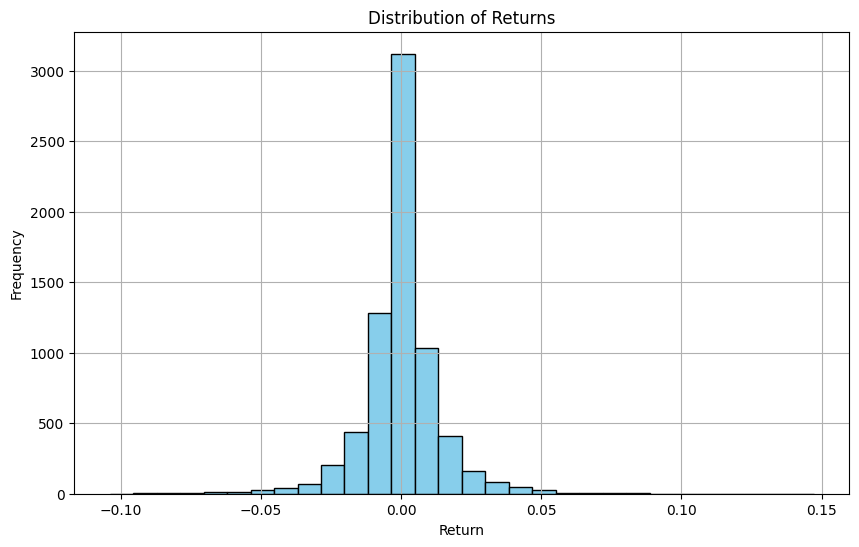

In [24]:
# 绘制返回率的直方图
plt.figure(figsize=(10, 6))
plt.hist(df['return'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
df['target'] = 1  # Initialize target column with zeros
df.loc[df['return'] > 0.03, 'target'] = 2  # Assign 1 where return is greater than 0.05
df.loc[df['return'] < -0.03, 'target'] = 0  # Assign -1 where return is less than -0.05

In [26]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return', 'MACD',
       'Signal Line', 'MACD_High', 'MACD_Histogram', 'MACD_Histogram_Low',
       'PPO', 'ADX', 'Volume_ADX', 'Momentum', 'CCI', 'ROC', '%K', '%D',
       'Williams %R', 'SMA20', 'SMA50', 'SMA100', 'EMA20', 'EMA50', 'EMA100',
       'Middle Band', 'Lower Band', 'Upper Band', 'PSAR', 'OBV',
       'Chaikin Oscillator', 'Money Flow Ratio', 'MFI', 'TR', 'ATR', 'RSI',
       'target'],
      dtype='object')

In [28]:
selected_features = ['open', 'high', 'low', 'close', 'volume', 'MACD',
       'Signal Line', 'MACD_High', 'MACD_Histogram', 'MACD_Histogram_Low',
       'PPO', 'ADX', 'Volume_ADX', 'Momentum', 'CCI', 'ROC', '%K', '%D',
       'Williams %R', 'SMA20', 'SMA50', 'SMA100', 'EMA20', 'EMA50', 'EMA100',
       'Middle Band', 'Lower Band', 'Upper Band', 'PSAR', 'OBV',
       'Chaikin Oscillator', 'Money Flow Ratio', 'MFI', 'TR', 'ATR', 'RSI',
       ]

X = df[selected_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)  # 保留95%方差的主成分
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])], index=df.index)
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
open_time,,,,,,,,,,
2021-01-17 08:00:00,0.542579,2.550778,-0.538583,0.780589,0.381754,0.824114,0.536019,-0.591084,0.959768,0.013700
2021-01-17 12:00:00,0.593256,2.422391,-0.144134,-0.141221,0.764528,0.057046,0.825204,-0.668393,1.120450,0.370181
2021-01-17 16:00:00,0.533876,1.932750,0.303553,-0.625712,0.249890,-0.456941,0.647646,-0.787520,0.393053,0.544431
2021-01-17 20:00:00,0.690334,1.514715,0.947762,-0.860096,0.540288,-0.374442,1.125722,0.075346,0.401708,0.305087
2021-01-18 00:00:00,0.601255,2.750516,0.739586,-2.265414,1.763770,-0.902077,1.780570,0.526517,0.314424,-0.015423
...,...,...,...,...,...,...,...,...,...,...
2024-03-26 04:00:00,9.911526,-5.088058,0.183167,-0.028947,-0.243795,1.740856,-0.552079,-0.275371,-1.226353,-0.957973
2024-03-26 08:00:00,9.925147,-5.013001,-0.381961,-0.265876,-0.013125,1.667286,-0.816526,-0.298528,-1.361561,-0.676681
2024-03-26 12:00:00,9.895675,-3.774219,-0.971935,1.524058,0.130900,1.563547,-0.167508,0.070375,-0.831550,-0.693837


In [29]:

wavelet = 'haar'
level = 5

for column in df_pca.columns:
    coeffs = pywt.wavedec(df_pca[column], wavelet, level=level)
    cA = coeffs[0]  
    cD = coeffs[1:]  
    reconstructed_signal = pywt.waverec(coeffs, wavelet)
    
    # 調整重建信號的長度與 DataFrame 索引長度匹配
    if len(reconstructed_signal) > len(df_pca):
        reconstructed_signal = reconstructed_signal[:-1]
    elif len(reconstructed_signal) < len(df_pca):
        reconstructed_signal = np.append(reconstructed_signal, reconstructed_signal[-1])
    
    df_pca[column] = reconstructed_signal

df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
open_time,,,,,,,,,,
2021-01-17 08:00:00,0.542579,2.550778,-0.538583,0.780589,0.381754,0.824114,0.536019,-0.591084,0.959768,0.013700
2021-01-17 12:00:00,0.593256,2.422391,-0.144134,-0.141221,0.764528,0.057046,0.825204,-0.668393,1.120450,0.370181
2021-01-17 16:00:00,0.533876,1.932750,0.303553,-0.625712,0.249890,-0.456941,0.647646,-0.787520,0.393053,0.544431
2021-01-17 20:00:00,0.690334,1.514715,0.947762,-0.860096,0.540288,-0.374442,1.125722,0.075346,0.401708,0.305087
2021-01-18 00:00:00,0.601255,2.750516,0.739586,-2.265414,1.763770,-0.902077,1.780570,0.526517,0.314424,-0.015423
...,...,...,...,...,...,...,...,...,...,...
2024-03-26 04:00:00,9.911526,-5.088058,0.183167,-0.028947,-0.243795,1.740856,-0.552079,-0.275371,-1.226353,-0.957973
2024-03-26 08:00:00,9.925147,-5.013001,-0.381961,-0.265876,-0.013125,1.667286,-0.816526,-0.298528,-1.361561,-0.676681
2024-03-26 12:00:00,9.895675,-3.774219,-0.971935,1.524058,0.130900,1.563547,-0.167508,0.070375,-0.831550,-0.693837


In [30]:
target_column = df['target']
df_pca = pd.concat([df_pca, target_column], axis=1)
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,target
open_time,,,,,,,,,,,
2021-01-17 08:00:00,0.542579,2.550778,-0.538583,0.780589,0.381754,0.824114,0.536019,-0.591084,0.959768,0.013700,1
2021-01-17 12:00:00,0.593256,2.422391,-0.144134,-0.141221,0.764528,0.057046,0.825204,-0.668393,1.120450,0.370181,1
2021-01-17 16:00:00,0.533876,1.932750,0.303553,-0.625712,0.249890,-0.456941,0.647646,-0.787520,0.393053,0.544431,1
2021-01-17 20:00:00,0.690334,1.514715,0.947762,-0.860096,0.540288,-0.374442,1.125722,0.075346,0.401708,0.305087,1
2021-01-18 00:00:00,0.601255,2.750516,0.739586,-2.265414,1.763770,-0.902077,1.780570,0.526517,0.314424,-0.015423,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 04:00:00,9.911526,-5.088058,0.183167,-0.028947,-0.243795,1.740856,-0.552079,-0.275371,-1.226353,-0.957973,1
2024-03-26 08:00:00,9.925147,-5.013001,-0.381961,-0.265876,-0.013125,1.667286,-0.816526,-0.298528,-1.361561,-0.676681,1
2024-03-26 12:00:00,9.895675,-3.774219,-0.971935,1.524058,0.130900,1.563547,-0.167508,0.070375,-0.831550,-0.693837,1


In [31]:
df_pca.reset_index(inplace=True)
train_data, test_data = train_test_split(df_pca, test_size=0.4, shuffle=False)

train_data.set_index('open_time', inplace=True)
test_data.set_index('open_time', inplace=True)

print("train data:", train_data.shape)
print("test data:", test_data.shape)

train data: (4192, 11)
test data: (2796, 11)


In [32]:
features_train = train_data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']].values
target_train = train_data[['target']].values

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.6, 0.7, 0.8],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    # 'reg_lambda': [0, 0.001, 0.01, 0.1, 1],
}

# Initialize XGBClassifier
xgb = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=100
)

# GridSearchCV 
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring={'Accuracy': 'accuracy'},
    refit='Accuracy',
    cv=5,
    n_jobs=-1
)

# Fit the model
grid_search.fit(features_train, target_train)

# Print best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best scores found:")
print("Accuracy:", grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7}
Best scores found:
Accuracy: 0.9403654196807769


In [33]:
best_params =  {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7} #4h0.03

model = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=100,
    **best_params
)

model.fit(features_train, target_train)

features_test = test_data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','PC10']].values
target_test = test_data['target'].values
y_pred = model.predict(features_test)

accuracy = accuracy_score(target_test, y_pred)
print("Accuracy on test set:", accuracy)

predicted_probabilities = model.predict_proba(features_test)
up = predicted_probabilities[:, 2]
down = predicted_probabilities[:, 0]
print("Probabilities of belonging to class 0 (fall):", down)
print("Probabilities of belonging to class 1 (rise):", up)
test_data['Predicted'] = y_pred
test_data['Probability_down'] = down
test_data['Probability_up'] = up
test_data


Accuracy on test set: 0.9839055793991416
Probabilities of belonging to class 0 (fall): [0.00585279 0.00473631 0.00507591 ... 0.01420821 0.00490546 0.00397142]
Probabilities of belonging to class 1 (rise): [0.00436872 0.0044541  0.00466872 ... 0.01332669 0.0047905  0.00481111]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,target,Predicted,Probability_down,Probability_up
open_time,,,,,,,,,,,,,,
2022-12-17 00:00:00,-6.260728,3.082740,-1.910551,-0.650447,0.824343,0.340599,-0.640190,-0.009409,-0.236620,-0.364542,1,1,0.005853,0.004369
2022-12-17 04:00:00,-6.204561,2.506817,-1.564667,-0.617578,0.309313,0.233158,-0.789240,-0.182897,-0.064005,-0.291487,1,1,0.004736,0.004454
2022-12-17 08:00:00,-6.206232,2.359515,-1.221874,-0.553160,-0.076724,-0.080842,-0.684783,-0.200515,-0.242021,-0.422469,1,1,0.005076,0.004669
2022-12-17 12:00:00,-6.210434,2.066917,-0.814271,-0.283111,-0.438373,-0.301644,-0.570520,-0.261862,-0.464251,-0.596719,1,1,0.005117,0.004451
2022-12-17 16:00:00,-6.164842,1.893384,-0.504831,-0.791977,-0.337349,-0.601399,-0.405678,-0.239168,-0.596092,-0.735206,1,1,0.004852,0.003970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 04:00:00,9.911526,-5.088058,0.183167,-0.028947,-0.243795,1.740856,-0.552079,-0.275371,-1.226353,-0.957973,1,1,0.005550,0.005793
2024-03-26 08:00:00,9.925147,-5.013001,-0.381961,-0.265876,-0.013125,1.667286,-0.816526,-0.298528,-1.361561,-0.676681,1,1,0.005059,0.005571
2024-03-26 12:00:00,9.895675,-3.774219,-0.971935,1.524058,0.130900,1.563547,-0.167508,0.070375,-0.831550,-0.693837,1,1,0.014208,0.013327


In [34]:
test_data.index = pd.to_datetime(test_data.index)

close_data = df.loc['2022-12-17':'2024-03-26', 'close']
open_data = df.loc['2022-12-17':'2024-03-26', 'open']
test_data['close'] = close_data
test_data['open'] = open_data

In [35]:
test_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,target,Predicted,Probability_down,Probability_up,close,open
open_time,,,,,,,,,,,,,,,,
2022-12-17 00:00:00,-6.260728,3.082740,-1.910551,-0.650447,0.824343,0.340599,-0.640190,-0.009409,-0.236620,-0.364542,1,1,0.005853,0.004369,16667.5,16624.1
2022-12-17 04:00:00,-6.204561,2.506817,-1.564667,-0.617578,0.309313,0.233158,-0.789240,-0.182897,-0.064005,-0.291487,1,1,0.004736,0.004454,16738.0,16667.5
2022-12-17 08:00:00,-6.206232,2.359515,-1.221874,-0.553160,-0.076724,-0.080842,-0.684783,-0.200515,-0.242021,-0.422469,1,1,0.005076,0.004669,16700.6,16737.9
2022-12-17 12:00:00,-6.210434,2.066917,-0.814271,-0.283111,-0.438373,-0.301644,-0.570520,-0.261862,-0.464251,-0.596719,1,1,0.005117,0.004451,16692.4,16700.6
2022-12-17 16:00:00,-6.164842,1.893384,-0.504831,-0.791977,-0.337349,-0.601399,-0.405678,-0.239168,-0.596092,-0.735206,1,1,0.004852,0.003970,16684.2,16692.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 04:00:00,9.911526,-5.088058,0.183167,-0.028947,-0.243795,1.740856,-0.552079,-0.275371,-1.226353,-0.957973,1,1,0.005550,0.005793,70535.0,70473.7
2024-03-26 08:00:00,9.925147,-5.013001,-0.381961,-0.265876,-0.013125,1.667286,-0.816526,-0.298528,-1.361561,-0.676681,1,1,0.005059,0.005571,70734.2,70535.0
2024-03-26 12:00:00,9.895675,-3.774219,-0.971935,1.524058,0.130900,1.563547,-0.167508,0.070375,-0.831550,-0.693837,1,1,0.014208,0.013327,70307.1,70734.1


In [36]:
test_data['status'] = test_data['Predicted'].shift(1).fillna(0)

test_data['buy_cost'] = test_data.open[((test_data.status == 2) & (test_data.status.shift(1) == 0)) | ((test_data.status == 2) & (test_data.status.shift(1) == 1))]
test_data['sell_cost'] = test_data.open[((test_data.status == 0) & (test_data.status.shift(1) == 1)) | ((test_data.status == 0) & (test_data.status.shift(1) == 2))]
test_data = test_data.fillna(0)

buy_cost = np.array(test_data.loc[test_data['buy_cost'] != 0, 'buy_cost'])
sell_price = np.array(test_data.loc[test_data['sell_cost'] != 0, 'sell_cost'])

if len(buy_cost) > len(sell_price):
    buy_cost = buy_cost[:len(sell_price)]

trade_return = sell_price / buy_cost - 1

fee = 0.002
net_trade_return = trade_return - fee

# 將報酬率放進表格中
test_data['trade_ret'] = 0.0  # 将初始值设置为 float64
test_data['net_trade_ret'] = 0.0  # 将初始值设置为 float64
sell_dates = test_data.sell_cost[test_data.sell_cost != 0].index
test_data.loc[sell_dates, 'trade_ret'] = trade_return
test_data.loc[sell_dates, 'net_trade_ret'] = net_trade_return

buy_dates = test_data[test_data['status'] == 2].index
sell_dates = test_data[test_data['status'] == 0].index

In [37]:
test_data['open_ret'] = test_data['open'] / test_data['open'].shift(1) - 1
test_data['strategy_ret'] = test_data['status'].shift(1) * test_data['open_ret']
test_data['strategy_net_ret'] = test_data['strategy_ret']
test_data.loc[sell_dates, 'strategy_net_ret'] = test_data.loc[sell_dates, 'strategy_net_ret'] - fee
test_data = test_data.fillna(0)

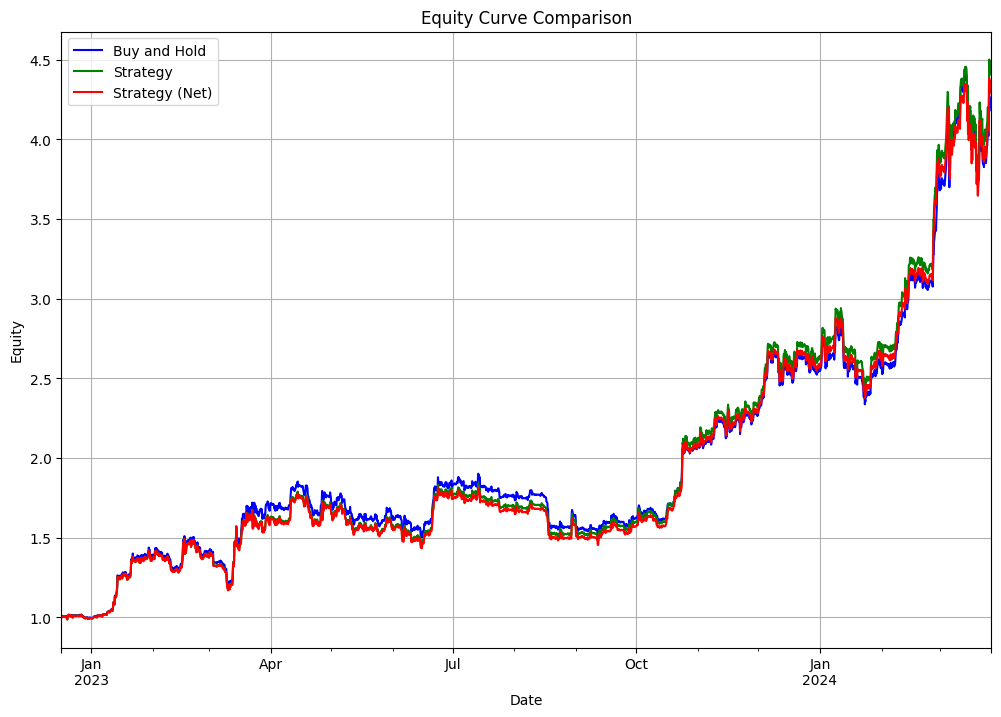

In [38]:
test_data['buy_and_hold_equity'] = (test_data['open_ret'] + 1).cumprod()
test_data['strategy_equity'] = (test_data['strategy_ret'] + 1).cumprod()
test_data['strategy_net_equity'] = (test_data['strategy_net_ret'] + 1).cumprod()

plt.figure(figsize=(12, 8))
test_data['buy_and_hold_equity'].plot(label='Buy and Hold', color='blue')
test_data['strategy_equity'].plot(label='Strategy', color='green')
test_data['strategy_net_equity'].plot(label='Strategy (Net)', color='red')


plt.title('Equity Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
fund = 0
test_data['equity'] = test_data['strategy_net_equity'] + fund
test_data['drawdown_percent'] = (test_data['equity'] / test_data['equity'].cummax()) - 1
test_data['drawdown'] = test_data['equity'] - test_data['equity'].cummax()
mdd = abs(test_data['drawdown_percent'].min())

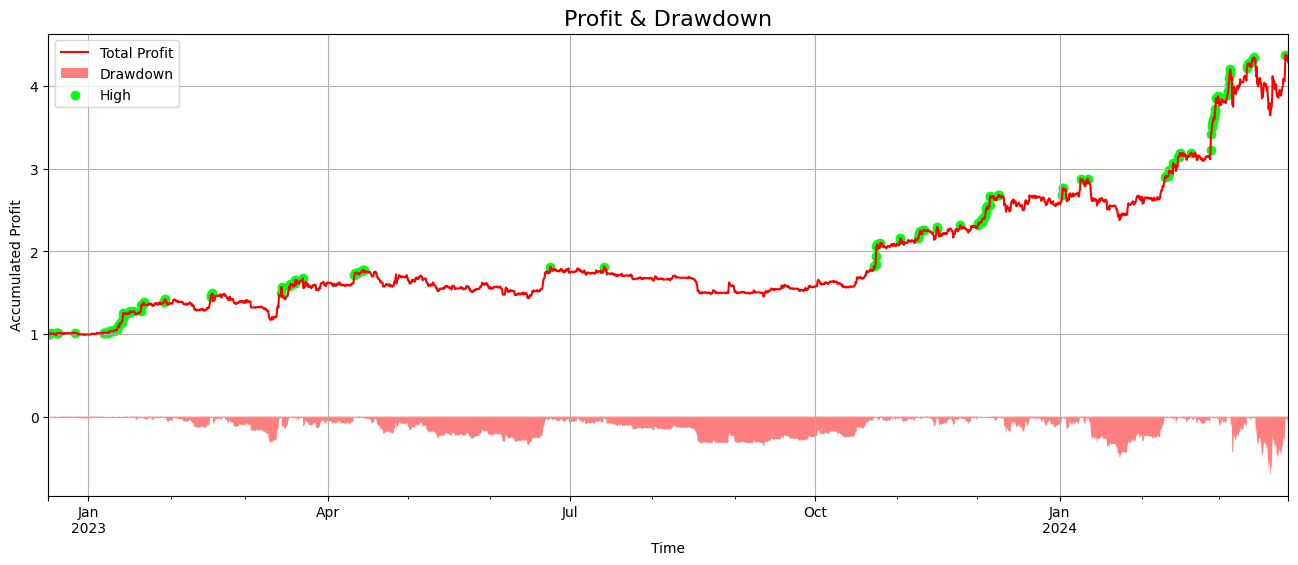

In [40]:
fig, ax = plt.subplots(figsize=(16, 6))

high_index = test_data[test_data['strategy_net_equity'].cummax() == test_data['strategy_net_equity']].index
test_data['strategy_net_equity'].plot(label='Total Profit', ax=ax, c='r', grid=True)
plt.fill_between(test_data['drawdown'].index, test_data['drawdown'], 0, facecolor='r', label='Drawdown', alpha=0.5)
plt.scatter(high_index, test_data['strategy_net_equity'].loc[high_index], c='#02ff0f', label='High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize=16)
plt.show()


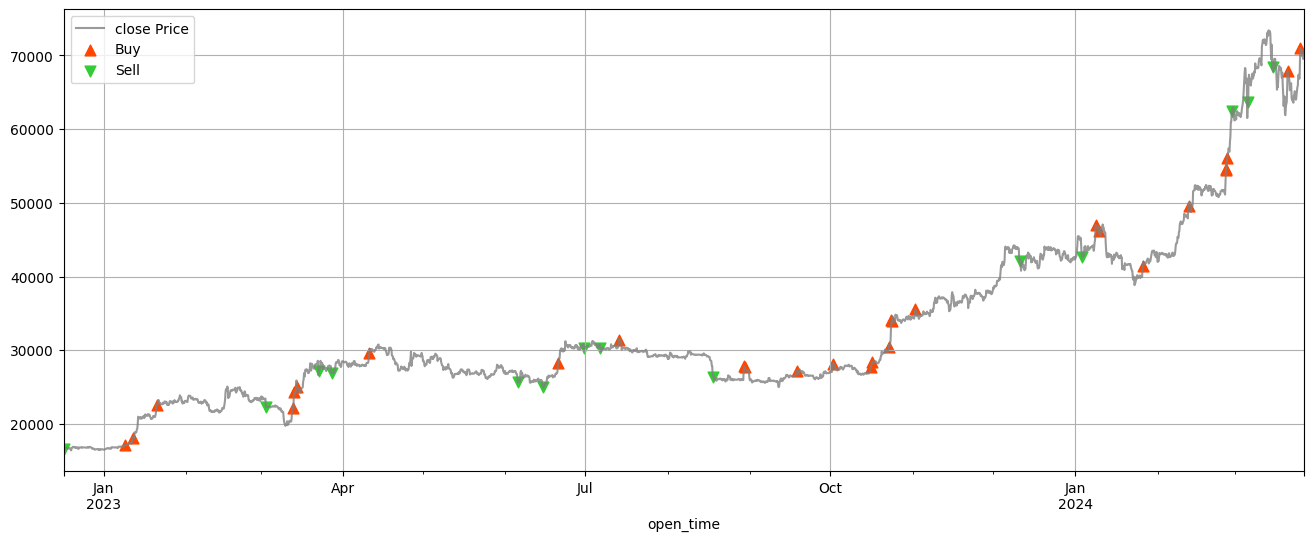

In [41]:
fig, ax = plt.subplots(figsize=(16, 6))
test_data['close'].plot(label='close Price', ax=ax, c='gray', grid=True, alpha=0.8)
if not buy_dates.empty:
    valid_buy_dates = buy_dates.intersection(test_data.index)
    plt.scatter(test_data['close'].loc[valid_buy_dates].index, test_data['close'].loc[valid_buy_dates], c='orangered',
                label='Buy', marker='^', s=60)
if not sell_dates.empty:
    valid_sell_dates = sell_dates.intersection(test_data.index)
    plt.scatter(test_data['close'].loc[valid_sell_dates].index, test_data['close'].loc[valid_sell_dates], c='limegreen',
                label='Sell', marker='v', s=60)
plt.legend()
plt.show()


In [42]:
strategy_net_ret = test_data['strategy_net_ret']
profit = test_data['strategy_net_equity'].iloc[-1]
ret = test_data['equity'].iloc[-1] / test_data['equity'].iloc[0] - 1
mdd = abs(test_data['drawdown_percent'].min())
calmarRatio = ret / mdd
trade_times = len(buy_dates) + len(sell_dates)
# win_rate = (strategy_net_ret > 0).sum() / trade_times
profit_factor = strategy_net_ret[strategy_net_ret > 0].sum() / abs(strategy_net_ret[strategy_net_ret < 0].sum())
winLossRatio = np.mean([i for i in strategy_net_ret if i > 0]) / abs(np.mean([i for i in strategy_net_ret if i < 0]))
arholdingperiod = (test_data.index[-1] - test_data.index[0]) / trade_times
strategy_ear = test_data['strategy_net_equity'].iloc[-1] ** (252 / len(test_data)) - 1
strategy_std = test_data.strategy_net_ret.std() * (252 ** 0.5)
strategy_sharpe = (strategy_ear - 0.01) / strategy_std


print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'Annualized Return: {np.round(strategy_ear * 100, 2)}%')
print(f'Annualized ST deviation: {np.round(strategy_std * 100, 2)}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {trade_times}')
# print(f'winRate: {np.round(win_rate,4)*100}%')
print(f'profitFactor: {np.round(profit_factor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'averageholdingperiod: {arholdingperiod}')
print(f'Sharpe Ratio: {np.round(strategy_sharpe, 2)}')




profit: $4.29
return: 328.87%
Annualized Return: 14.02%
Annualized ST deviation: 15.52%
mdd: 21.6%
calmarRatio: 15.23
tradeTimes: 42
profitFactor: 1.21
winLossRatio: 1.1
averageholdingperiod: 11 days 02:11:25.714285714
Sharpe Ratio: 0.84
